In [2]:
import numpy as np
import pandas as pd

In [42]:
# Initialize functions used multiple times throughout the notebook
def plot_patient_scores(dataframe, patient_id):
    plot_df = dataframe[df.patient_id == patient_id]
    plot_df.plot(x='date', y='score', ylim=(0,22), grid=True, yticks=range(22), 
        title=f"Patient {patient_id} GAD-7 Results", ylabel='score',
        legend=False)

## Basic Assumptions
- `patient_date_created` is always earlier than `date` and is constant for a given `patient_id`.
    - Untrue for only 1 row of the > 1,000,000 in the data set, so this seems to be a fairly safe assumption.
- All tests administered are GAD-7, so the `type` column can be dropped without a hassle.
- Any rows that are duplicates of another are accidental entries, and are safe to discard.

In [4]:
df = pd.read_csv('phq_all_final.csv')
df.drop_duplicates(inplace=True)
df.sort_values(by=['patient_date_created', 'date'], inplace=True)
df.drop(labels=['type'], axis='columns', inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['patient_date_created'] = pd.to_datetime(df['patient_date_created'])
df.head()

,date,patient_id,patient_date_created,score
0,2019-08-26 13:32:43.019162,8430,2019-06-03 13:23:02.635680,6
1,2019-11-15 17:55:11.364877,8430,2019-06-03 13:23:02.635680,1
2,2019-10-07 18:23:29.611351,14338,2019-06-03 13:32:30.668460,10
3,2019-11-04 20:16:28.610965,14338,2019-06-03 13:32:30.668460,7
4,2019-12-02 20:56:55.966354,14338,2019-06-03 13:32:30.668460,9


In [46]:
grouped = df.groupby(['patient_id', 'patient_date_created'], sort=False)
agg_df = grouped.agg(
    first_date = ('date', 'first'),
    last_date = ('date', 'last'),
    first_score = ('score', 'first'),
    last_score = ('score', 'last'),
    max_score = ('score', 'max'),
    min_score = ('score', 'min'),
    test_count = ('score', 'count')
).reset_index()
agg_df.head()

,patient_id,patient_date_created,first_date,last_date,first_score,last_score,max_score,min_score,test_count
0,8430,2019-06-03 13:23:02.635680,2019-08-26 13:32:43.019162,2019-11-15 17:55:11.364877,6,1,6,1,2
1,14338,2019-06-03 13:32:30.668460,2019-10-07 18:23:29.611351,2019-12-02 20:56:55.966354,10,9,10,7,3
2,17028,2019-06-03 14:24:06.741810,2019-09-17 14:08:49.642430,2019-11-11 14:42:40.889057,6,9,9,6,2
3,3788,2019-06-03 14:48:09.129756,2019-06-07 13:05:01.435941,2019-08-10 04:44:56.461089,0,0,2,0,7
4,6292,2019-06-03 15:13:41.387077,2019-07-16 14:32:59.141021,2019-09-10 14:19:42.829505,5,1,5,1,3


## Tracking Individual Progress
At the most basic level, we can track a patient's individual GAD-7 results over time.  This information could be shared with the patient to keep them informed of their progress.  The major drawback of such an approach is that without frequent and regular tests, it can be difficult to discern trends in an individual's anxiety levels. For example, Patient 10687 has had 84 GAD-7 tests over the course of 5 months, with relatively clear peaks and valleys over the course of 5 months.  Meanwhile, Patient 14338 has had only 3 tests over the course of approximately 3 months, with an unclear trajectory of progress.

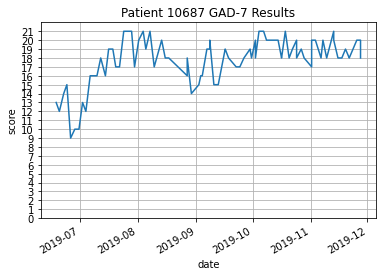

In [48]:
# Use aggregated dataframe to find the patient(s) with the highest number of tests
max_tests = agg_df.max(axis='rows')['test_count']
most_tests_patient_id = agg_df[agg_df.test_count == max_tests].reset_index().at[0, 'patient_id']

# Plot the test results for the patient with highest number of tests
plot_patient_scores(df, most_tests_patient_id)

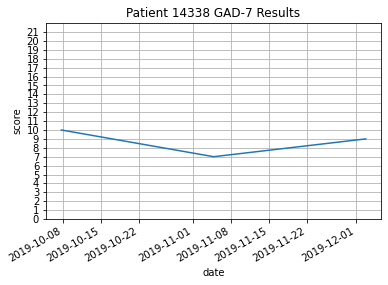

In [47]:
patient_id = 14338
plot_patient_scores(df, patient_id)

## Comparing Individuals' Progress to the Population's
With a reasonable sample of data charting a patient's progress, we can calculate a rate of change in the patient's GAD-7 score over time.  For the sake of this problem, I am going to assume that progress is relatively linear with regards to time, with an expected trend of decreasing score as treatment improves a patient's anxiety.  

If we calculate all patients' rates of progression, we can then aggregate the GAD-7 score's rate of change for all patients.  I choose to find the median and quartiles in this case to reduce the impact of outlier rates of change.  This median can establish a useful prior expectation for an individual's rate of progress.  If a patient is progressing at a lower rate than the median, this may indicate the need for a change in treatment or methodology in order to improve effectiveness.

At a provider level, these median rates of progression can be used to track the overall efficacy of the provider's clinicians and set goals for improving that efficacy.

Lastly, it may be prudent to separate patients by their maximum score along the GAD-7 scale, as it is likely that patients that had a Moderate or Severe score in the past will receive a different level of treatment for their anxiety than patients with only Low or Mild maximum anxiety.

## Acquiring Additional Information
If the following information were provided with the data set, we could draw additional insights about the patients and clinicians treating them:
1. Answers to each GAD-7 question: This could be used to determine whether a specific facet of anxiety is being addressed by treatment, and could be used to determine which aspects of anxiety are the most responsive to treatment across the population.
2. Clinician IDs: This information could be used to determine a given clinician's efficacy at treating their patients, which could in turn designate which clinicians may require assistance in the practice or provide a measurement for clinician performance reviews.
3. Patient demographic information: Information such as racial/ethnic background, gender, sexual orientation, age, and financial means could help determine which demographics may need additional care or alternative approaches to treatment to improve efficacy.